In [1]:
### Introduction and important caveats

# This notebook addresses the challenges of classifying new customers based on previous customer data 
# regarding the purchase of term deposits for a bank. The challenge and data are avaiailable at Kaggle:
# https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets
# The author of the challenge requires that we cite the original article analyzing this dataset:
# S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing.
# Decision Support Systems, Elsevier, 62:22-31, June 2014

# According to the authors of the article, this dataset is real world data adapted for public use:
# "Real-world data were collected from a Portuguese marketing campaign 
# related with bank deposit subscription." (MORO, S. & CORTEZ, P. 2011, p. 1)
# We have not read the article or challenge submissions so our analysis is not skewed.

## Data cleaning, preparation and transformation strategies

# According to the authors of the challenge on Kaggle, the data is relatively clean and without missing values on the 18 columns
# However, we see the following problems with the data that must be addressed first:
# 1. Obtain the year variable, dates can be important to detect economic and business fluctuations
# 2. Convert 'unknown' and '-1' values to missing and decide for imputation, feature engineering or dropping
# 3. Convert string columns to boolean and categorical
# 4. Transform categorical collumns to dummie columns
# 5. Address class imbalance in label 'y' with resampling (therefore, we will not use the suggested test split)


### Importing Required Packages and Modules

## Importing Packages

import pandas as pd
import numpy as np
from calendar import month_abbr
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt


C:\Users\joseph.pavao_tc\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
### Loading and Cleaning Data

## Loading data from local file downloaded from Kaggle challenge page and marking origin 

test = pd.read_csv('test.csv', sep=';')
train = pd.read_csv('train.csv', sep=';')

## Checking if Test records are contained in Train, since this is not clear

# Creating 'origin' collumn for identification after combining
test = test.assign(origin='test')
train = train.assign(origin='train')

# Combining Training and Test datasets
combined = pd.concat([train, test])

# Creating 'dup' column to identify any duplicates
combined['dup'] = combined.drop(['origin'], axis = 1).duplicated()

rows_dup = combined[(combined.dup == True)].shape[0]
print('Rows duplicated in combined dataset: %s' % (rows_dup))

uniq_rec = combined[(combined.origin == 'test') & (combined.dup == False)].shape[0]
print('Unique rows in test dataset: %s' % (uniq_rec))

# We can see that all records in 'test' are also in 'train', so we can procede with only train, which we will rename to df
# After droppinh the no longer needed origin collumn

df = train.drop(['origin'], axis=1)

Rows duplicated in combined dataset: 4521
Unique rows in test dataset: 0


In [3]:
## Obtaining year variable
start_09 = df[df.month == 'jan'].index[1]
end_09 = df[df.month == 'dec'].index[-1]
end_08 = start_09 -1
start_10 = end_09 +1

df_08 = df.iloc[:end_08,:].assign(year=2008)
df_09 = df.iloc[start_09:end_09,:].assign(year=2009)
df_10 = df.iloc[start_10:,:].assign(year=2010)

df_year = pd.concat([df_08, df_09, df_10])

# Converting month to numeric
df_year['month'] = df_year.month.str.title()
abbr_to_num = {name: num for num, name in enumerate(month_abbr) if num}
df_year['month'] = df_year.month.map(abbr_to_num)

In [4]:
## Addressing 'unknown' values in datasets

df_year.replace(to_replace='unknown', value=np.nan, inplace=True)

# Here we address the '-1' value in pdays collumn to create a new feature 'contacted in previous campaign'
df_year['contact_prev_camp'] = np.select([df_year.pdays == -1, df_year.pdays != -1], ['no', 'yes'])
df_year.pdays.replace(to_replace=-1, value=np.nan, inplace=True)

# Let´s investigate presence of missing values
print('df missing percentages: ')
print(df.isnull().mean())

# Considering close to 80% of records contain missing values for pdays and poutcome and 30% for contact,
# we will drop these features

redu = ['pdays', 'poutcome', 'contact']
df_redu = df_year.drop(columns=redu)


df missing percentages: 
age          0.0
job          0.0
marital      0.0
education    0.0
default      0.0
balance      0.0
housing      0.0
loan         0.0
contact      0.0
day          0.0
month        0.0
duration     0.0
campaign     0.0
pdays        0.0
previous     0.0
poutcome     0.0
y            0.0
dtype: float64


In [5]:
## Converting yes/no variables to 1 and 0

# Eye-balling yes/no variables
print('First 5 rows of df_redu')
print(df_redu.head())

# Defining columns
yesno = ['default', 'housing', 'loan', 'y', 'contact_prev_camp']

# Replacing values
df_redu[yesno] = df_redu[yesno].replace(to_replace=['no', 'yes'], value=[0, 1])

First 5 rows of df_redu
   age           job  marital  education default  balance housing loan  day  \
0   58    management  married   tertiary      no     2143     yes   no    5   
1   44    technician   single  secondary      no       29     yes   no    5   
2   33  entrepreneur  married  secondary      no        2     yes  yes    5   
3   47   blue-collar  married        NaN      no     1506     yes   no    5   
4   33           NaN   single        NaN      no        1      no   no    5   

   month  duration  campaign  previous   y  year contact_prev_camp  
0      5       261         1         0  no  2008                no  
1      5       151         1         0  no  2008                no  
2      5        76         1         0  no  2008                no  
3      5        92         1         0  no  2008                no  
4      5       198         1         0  no  2008                no  


In [117]:
## Mising Data - education and job variables
# Investigating if education and job are MCAR for less than 5% of data

# Obtaining the modes of education and job in full dataset
mode_educ = str(df_redu['education'].mode()[0])
mode_job = str(df_redu['job'].mode()[0])

print('Education Most Frequent Value: %s' % (mode_educ))
print('Job Most Frequent Value: %s' % (mode_job))

# Checking conversion rate for mode categories and missing
conv_rate_sec_educ = round(df_redu[(df_redu.education == 'secondary') & (df_redu.y == 1)].shape[0] / df_redu[df_redu.education == 'secondary'].shape[0], 2)
print('Conversion Rate for Secondary Educ: %s' % (conv_rate_sec_educ))

conv_rate_missing_educ = round(df_redu[(df_redu.education.isnull()) & (df_redu.y == 1)].shape[0] / df_redu[df_redu.education.isnull()].shape[0], 2)
print('Conversion Rate for unknown Educ: %s' % (conv_rate_missing_educ))

conv_rate_bluec_job = round(df_redu[(df_redu.job == 'blue-collar') & (df_redu.y == 1)].shape[0] / df_redu[df_redu.job == 'blue-collar'].shape[0], 2)
print('Conversion Rate for Blue-Collar Job: %s' % (conv_rate_bluec_job))

conv_rate_missing_job = round(df_redu[(df_redu.job.isnull()) & (df_redu.y == 1)].shape[0] / df_redu[df_redu.job.isnull()].shape[0], 2)
print('Conversion Rate for unknown Job: %s' % (conv_rate_missing_job))

# As we can see, the differences in outcomes among these groups DO NOT WARRENT 100% the use of Mode Imputation.
# Therefore, we will drop the lines with missing values in these columns

df_clean = df_redu.dropna()
nrows_full = df_redu.shape[0]
nrows_clean = df_clean.shape[0]

print('Number of rows in full dataset: %s' % (nrows_full))
print('Number of rows in data dataset: %s' % (nrows_clean))

#Final checks for completeness of datasetsa

print('df_clean missing percentages')
print(df_clean.isnull().mean())

df_clean.head()


Education Most Frequent Value: secondary
Job Most Frequent Value: blue-collar
Conversion Rate for Secondary Educ: 0.11
Conversion Rate for unknown Educ: 0.14
Conversion Rate for Blue-Collar Job: 0.07
Conversion Rate for unknown Job: 0.12
Number of rows in full dataset: 45209
Number of rows in data dataset: 43192
df_clean missing percentages
age                  0.0
job                  0.0
marital              0.0
education            0.0
default              0.0
balance              0.0
housing              0.0
loan                 0.0
day                  0.0
month                0.0
duration             0.0
campaign             0.0
previous             0.0
y                    0.0
year                 0.0
contact_prev_camp    0.0
dtype: float64


,age,job,marital,education,default,balance,housing,loan,day,month,duration,campaign,previous,y,year,contact_prev_camp
0,58,management,married,tertiary,0,2143,1,0,5,5,261,1,0,0,2008,0
1,44,technician,single,secondary,0,29,1,0,5,5,151,1,0,0,2008,0
2,33,entrepreneur,married,secondary,0,2,1,1,5,5,76,1,0,0,2008,0
5,35,management,married,tertiary,0,231,1,0,5,5,139,1,0,0,2008,0
6,28,management,single,tertiary,0,447,1,1,5,5,217,1,0,0,2008,0


In [118]:
## Preparing our Data for XGBoost - Encoding Categorical Variavles 

# Defining Categorical Collumns
cats = ['job', 'marital', 'education']

# Converting Strings to Category Variables
df_clean[cats] = df_clean[cats].astype('category')

# One-Hot Encoding of Categorical Variables
df_clean = pd.get_dummies(df_clean, columns=cats, prefix=['j', 'ma', 'e'], drop_first=True)

# Converting Boolean Variables
try:
    yesno.remove('y')
except:
    print('y already removed')

df_clean[yesno] = df_clean[yesno].astype('bool')

y already removed


C:\Users\joseph.pavao_tc\AppData\Local\Temp\ipykernel_19412\3407912237.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[cats] = df_clean[cats].astype('category')


Full Feature Normalized Variance:
age                  6.650542e-02
default              5.423399e+01
balance              5.047941e+00
housing              7.781251e-01
loan                 5.077506e+00
day                  2.760280e-01
month                1.534415e-01
duration             9.987244e-01
campaign             1.234022e+00
previous             1.590826e+01
y                    7.602446e+00
year                 8.913434e-08
contact_prev_camp    4.459843e+00
j_blue-collar        3.655398e+00
j_entrepreneur       2.961160e+01
j_housemaid          3.514475e+01
j_management         3.687226e+00
j_retired            1.913657e+01
j_self-employed      2.704738e+01
j_services           9.787439e+00
j_student            5.473288e+01
j_technician         4.872581e+00
j_unemployed         3.290343e+01
ma_married           6.647678e-01
ma_single            2.534882e+00
e_secondary          8.672978e-01
e_tertiary           2.257122e+00
dtype: float64
Correlation Heatmaps: Full & Redu

<AxesSubplot:>

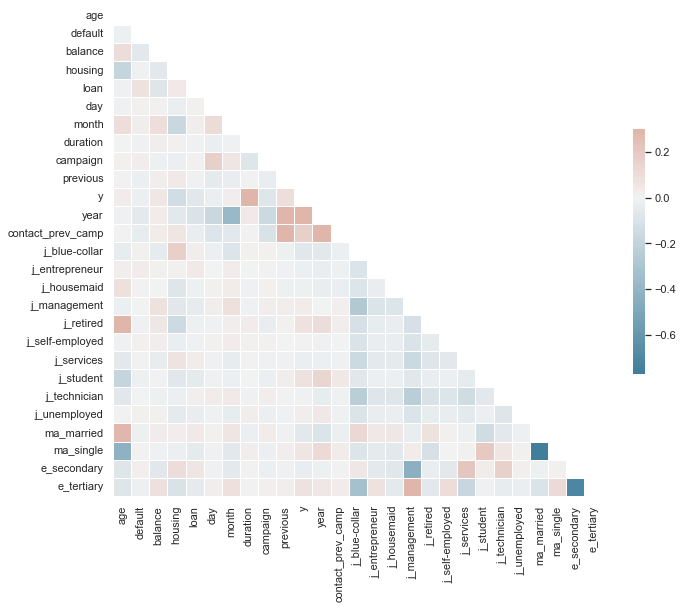

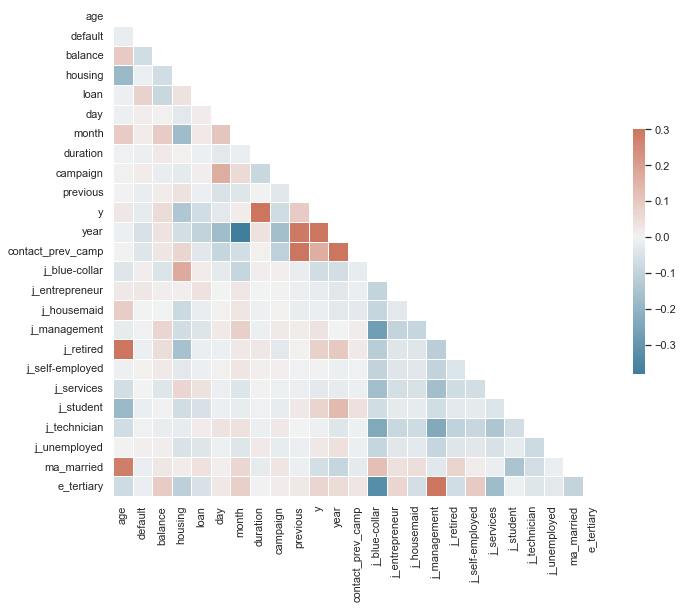

In [126]:
## Investigating All Feature Variance and Covariance

df_norm = df_clean / df_clean.mean()
print('Full Feature Normalized Variance:')
print(df_norm.var())

# Only the 'year' variable that we've constructed has a variance with order of magnitude in the 100 millionth (8.913434e-08)
# but we will keep it for now since it may help model prediction

## Plotting Feature Correlations
import seaborn as sns

# Correlation Matrix
corr = df_clean.corr()

# Setting up Correlation Heatmap plot
print('Correlation Heatmaps: Full & Reduced Feature sets')
sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# We see that ma_married is highly correlated with ma_single, as e_secondary is with e_tertiary. We will drop one of each.

redund = ['ma_single', 'e_secondary']

df_redu = df_clean.drop(redund, axis=1)

corr = df_redu.corr()

sns.set_theme(style="white")
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Feature Correlation seems within acceptable bounds after removing redundant variables

In [127]:
## Dealing with class imbalance

bal = round(df_redu.y.value_counts()[1] / df_redu.shape[0], 2)
print('Percent of positive class in sample: %s' % (bal))
print('Number of obs:', df_redu.shape[0])

# Upsampling minority class
min = df_redu[df_redu.y == 1]
maj = df_redu[df_redu.y == 0]
min_up = resample(min, replace=True, n_samples=maj.shape[0])
df_bal = pd.concat([maj, min_up])

# Checking Balance of New dataframe

bal = round(df_bal.y.value_counts()[1] / df_bal.shape[0], 2)
print('-----------------------------------------------')
print('Percent of positive class in sample: %s' % (bal))
print('Number of obs:', df_bal.shape[0])

Percent of positive class in sample: 0.12
Number of obs: 43192
-----------------------------------------------
Percent of positive class in sample: 0.5
Number of obs: 76342


In [128]:
# Splitting data - 80% for training and tuning, 20% held out for performance validation

X_train, X_test, y_train, y_test = train_test_split(df_bal.drop('y', axis=1), df_bal['y'], test_size=0.2, random_state=123)

In [129]:
## Training the Model
from sklearn.metrics import f1_score, roc_auc_score

# Instantiating Classifier
xgb_clf = xgb.XGBClassifier(objective = 'reg:logistic'
                            , n_estimators = 10
                            , seed = 100
                            , eval_metric=roc_auc_score)

# Fiitting Model to Training Data
xgb_clf.fit(X_train, y_train)


C:\Users\joseph.pavao_tc\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\joseph.pavao_tc\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x00000254C77304C0>,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=8,
              num_parallel_tree=1, objective='reg:logistic', predictor='auto',
              random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=100, subsample=1, tree_method='exact', validate_parameters=1, ...)

In [130]:
## Plotting Feature Importances
print('Feature Importances in XGBoost Classifier: ')
print(pd.DataFrame(xgb_clf.feature_importances_, index=X_test.columns
                   , columns=['feature_importance']).sort_values(by='feature_importance', axis=0, ascending=False))

# We can see that year, housing and duration have the strongest feature importance for our simple model
# while contact_prev_camp, j_entrepreneur, j_student, j_technician have zero importance for model predictions

Feature Importances in XGBoost Classifier: 
                   feature_importance
year                         0.292092
housing                      0.290460
duration                     0.197266
month                        0.057115
e_tertiary                   0.030663
day                          0.027906
default                      0.017288
j_management                 0.011727
balance                      0.010877
loan                         0.010700
age                          0.010128
j_blue-collar                0.008349
campaign                     0.008267
previous                     0.007886
ma_married                   0.006375
j_housemaid                  0.003924
j_retired                    0.002967
j_unemployed                 0.002719
j_self-employed              0.002683
j_services                   0.000609
contact_prev_camp            0.000000
j_entrepreneur               0.000000
j_student                    0.000000
j_technician                 0.000000


In [131]:
### Making Predictions on the Test Set and Evaluating Model Performance
from sklearn.metrics import classification_report, roc_auc_score

y_pred_train = xgb_clf.predict(X_train)
y_pred = xgb_clf.predict(X_test)

## Evaluating Model Performance

# Computing Accutacy
print('Train Accuract Score:', accuracy_score(y_train, xgb_clf.predict(X_train)))
print('Test Accuracy Score:', accuracy_score(y_test, y_pred))

# Displaying Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=xgb_clf.classes_)

print(classification_report(y_train, y_pred_train))
print('-----------------------------------------------')
print(classification_report(y_test, y_pred))
print('ROC AUC score: %s' % (roc_auc_score(y_test, y_pred)))

# As we can see, the model is not overfitting the training data, which is positive

C:\Users\joseph.pavao_tc\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Train Accuract Score: 0.8899022481292879
Test Accuracy Score: 0.8914794682035497
              precision    recall  f1-score   support

           0       0.93      0.84      0.88     30540
           1       0.85      0.94      0.90     30533

    accuracy                           0.89     61073
   macro avg       0.89      0.89      0.89     61073
weighted avg       0.89      0.89      0.89     61073

-----------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.85      0.89      7631
           1       0.86      0.94      0.90      7638

    accuracy                           0.89     15269
   macro avg       0.89      0.89      0.89     15269
weighted avg       0.89      0.89      0.89     15269

ROC AUC score: 0.89145845821414


In [132]:
## Hyperpamater Tuning

# Let´s see how much we can improve our baseline performance of 89% ROC AUC score
# Now using cross-validation, 5-fold for symetry with the validation hold-out proportion - This takes a few minutes

params_grid = {
    'n_estimators': [200, 500, 750, 900],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1, 1.5, 2],
    'reg_alpha': [0, 0.1, 0.5, 1, 1.5, 2],
    'reg_lambda': [0, 0.1, 0.5, 1, 1.5, 2],
    'base_score': [0.001, 0.025, 0.05, 0.1],
    'max_depth' : [3, 6, 10, 15]
}

rs = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1, eval_metric=roc_auc_score), params_grid, n_jobs=-1, cv=5, scoring='roc_auc')
rs.fit(X_train, y_train)

print('Best params:', rs.best_params_)
print('Best score:', rs.best_score_)

# As we start to allow more extreme hyperparameter values, our model starts overfitting
# at around 99% ROC AUC for the full training set and 95,8% of the test hold-out set

C:\Users\joseph.pavao_tc\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\joseph.pavao_tc\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:20:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'reg_lambda': 1.5, 'reg_alpha': 0.5, 'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.1, 'gamma': 1, 'booster': 'gbtree', 'base_score': 0.1}
Best score: 0.9842886518324322


In [133]:
## Evaluating Tuned Model Performance

y_train_pred = rs.predict(X_train)
y_pred = rs.predict(X_test)

print('Classification Report Training: ')
print(classification_report(y_train, y_train_pred))
print('Roc auc score training: ', roc_auc_score(y_train, y_train_pred))
print('-----------------------------------------------')
print('Classification Report Test Data: ')
print(classification_report(y_test, y_pred))
print('Roc auc score test', roc_auc_score(y_test, y_pred))

Classification Report Training: 
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     30540
           1       0.98      1.00      0.99     30533

    accuracy                           0.99     61073
   macro avg       0.99      0.99      0.99     61073
weighted avg       0.99      0.99      0.99     61073

Roc auc score training:  0.9916993730746324
-----------------------------------------------
Classification Report Test Data: 
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      7631
           1       0.92      1.00      0.96      7638

    accuracy                           0.96     15269
   macro avg       0.96      0.96      0.96     15269
weighted avg       0.96      0.96      0.96     15269

Roc auc score test 0.958263011477728


In [134]:
best = rs.best_estimator_

## Plotting Feature Importances
print('Feature Importances in XGBoost Classifier: ')
print(pd.DataFrame(best.feature_importances_, index=X_test.columns
                   , columns=['feature_importance']).sort_values(by='feature_importance', axis=0, ascending=False))

# We can see that year, housing and duration continue to tbe the most important features in model predictions
# and only contact_prev_camp has zero importance

Feature Importances in XGBoost Classifier: 
                   feature_importance
year                         0.401193
housing                      0.096791
duration                     0.094990
month                        0.059828
day                          0.029051
default                      0.023889
e_tertiary                   0.021185
j_blue-collar                0.020973
loan                         0.020496
campaign                     0.018375
j_entrepreneur               0.018066
j_services                   0.017852
j_self-employed              0.017829
ma_married                   0.017326
j_housemaid                  0.017139
balance                      0.017131
age                          0.016204
j_technician                 0.016076
j_retired                    0.015892
j_management                 0.015723
previous                     0.014856
j_student                    0.014772
j_unemployed                 0.014365
contact_prev_camp            0.000000


In [135]:
## Hyperpamater Tuning - Part 2

# Let´s see if we can improve our tuned-model performance of 95.8% ROC AUC score on the hold-out test set
# This takes a few minutes

params_grid = {
    'n_estimators': [200, 500, 750, 900],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'booster': ['gbtree', 'gblinear'],
    'gamma': [0, 0.5, 1, 1.5, 2],
    'reg_alpha': [0, 0.1, 0.5, 1, 1.5, 2],
    'reg_lambda': [0, 0.1, 0.5, 1, 1.5, 2],
    'base_score': [0.001, 0.025, 0.05, 0.1],
    'max_depth' : [3, 6, 10, 15]
}

rs = RandomizedSearchCV(xgb.XGBClassifier(n_jobs=-1, eval_metric=roc_auc_score), params_grid, n_jobs=-1, cv=5, scoring='roc_auc')
rs.fit(X_train.drop('contact_prev_camp', axis=1), y_train)

print('Best params:', rs.best_params_)
print('Best score:', rs.best_score_)

# We don´t get better performance, but we get more overfitting
# at around 99.5% ROC AUC for the full training set and 95,79% of the test hold-out set

C:\Users\joseph.pavao_tc\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\joseph.pavao_tc\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[17:47:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best params: {'reg_lambda': 2, 'reg_alpha': 2, 'n_estimators': 900, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.5, 'booster': 'gbtree', 'base_score': 0.025}
Best score: 0.9857643799340128


In [136]:
## Evaluating Tuned Model Performance - Part 2

y_train_pred = rs.predict(X_train.drop('contact_prev_camp', axis=1))
y_pred = rs.predict(X_test.drop('contact_prev_camp', axis=1))

print('Classification Report Training: ')
print(classification_report(y_train, y_train_pred))
print('Roc auc score training: ', roc_auc_score(y_train, y_train_pred))
print('-----------------------------------------------')
print('Classification Report Test Data: ')
print(classification_report(y_test, y_pred))
print('Roc auc score test', roc_auc_score(y_test, y_pred))

C:\Users\joseph.pavao_tc\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\joseph.pavao_tc\anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Classification Report Training: 
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     30540
           1       0.99      1.00      1.00     30533

    accuracy                           1.00     61073
   macro avg       1.00      1.00      1.00     61073
weighted avg       1.00      1.00      1.00     61073

Roc auc score training:  0.9954813059253249
-----------------------------------------------
Classification Report Test Data: 
              precision    recall  f1-score   support

           0       1.00      0.92      0.96      7631
           1       0.92      1.00      0.96      7638

    accuracy                           0.96     15269
   macro avg       0.96      0.96      0.96     15269
weighted avg       0.96      0.96      0.96     15269

Roc auc score test 0.9579353403684184


In [139]:
best = rs.best_estimator_

## Plotting Feature Importances
print('Feature Importances in XGBoost Classifier: ')
print(pd.DataFrame(best.feature_importances_, index=X_test.drop('contact_prev_camp', axis=1).columns
                   , columns=['feature_importance']).sort_values(by='feature_importance', axis=0, ascending=False))

Feature Importances in XGBoost Classifier: 
                 feature_importance
year                       0.449020
housing                    0.105586
duration                   0.091269
month                      0.059999
default                    0.027703
day                        0.021983
j_blue-collar              0.019174
e_tertiary                 0.018791
j_retired                  0.016072
loan                       0.016053
j_entrepreneur             0.015321
campaign                   0.015226
j_housemaid                0.015080
ma_married                 0.014453
balance                    0.014239
j_services                 0.013919
previous                   0.013653
age                        0.013650
j_self-employed            0.013511
j_management               0.012279
j_technician               0.011454
j_unemployed               0.010947
j_student                  0.010618


In [140]:
## We can conclude that a high perfomance classifier is achievable with the data provided.
# The steps we employed are as follows:

# 1. Cleaning and standardizing data, allowing the use of a wide range of tools
# 2. Feature Engineering, especially the construction of the 'year' variable which proved most important of all
# 3. Balancing the dataset with upsampling on the minority class, allowing us to follow through with tools for balanced data
# 4. Using a tree-based model out of the box like xgboost brings feature selection and a 89% ROC AUC score on the validation set.
# 5. Tuning hyperparameters with Random Search brings our validaction ROC AUC score to over 95%, with accuracy balanced between classes.